In [33]:
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

import sys
sys.path.append("..")
from src.utils.io import get_path, var_to_str
from src.utils.data import load_dataset

In [34]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 27
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [35]:
l2_reg = 1.0
shift_cost = 1.0
result_dir = "../results"

In [36]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "srda",
        "label": "SRDA",
        "color": "darkgray",
        "linestyle": "solid",
        "marker": "+",
    },
    {
        "optimizer": "saddlesaga",
        "label": "SaddleSAGA",
        "color": "goldenrod",
        "linestyle": "solid",
        "marker": "+",
    },
    {
        "optimizer": "lsvrg",
        "label": "LSVRG",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    {
        "optimizer": "prospect",
        "label": "Prospect (Ours)",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "o",
    },
]

In [39]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def plot_traj(
    ax,
    dataset,
    model_cfg,
    plot_cfg,
    seeds,
    out_path="../results/",
    verbose=False,
    n_points=16,
    markersize=8,
    n_epochs=None,
):
    filename = plot_cfg["optimizer"]  # "code" name (e.g. "lsvrg")
    label = plot_cfg["label"]  # display name
    color = plot_cfg["color"]
    linestyle = plot_cfg["linestyle"]

    X_train = load_dataset(dataset, data_path="../data/")[0]
    n = len(X_train)
    d = X_train.shape[1]

    path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
   
    df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
    opt = pickle.load(open(os.path.join(path, "best_cfg.p"), "rb"))
    if verbose:
        print(f"{filename} best config:", opt)
    avg_train_loss = torch.tensor(df["average_train_loss"])
    epoch_len = opt["epoch_len"]

    epochs = torch.arange(len(avg_train_loss))
    subopt = get_suboptimality(
        dataset, model_cfg, avg_train_loss, out_path=out_path
    )
    if filename == "lsvrg":
        if epoch_len:
            x = epochs * (epoch_len + n) / n
        else:
            x = epochs * 2
    elif filename == "moreau":
        if epoch_len:
            x = epochs * 2 * epoch_len / n
        else:
            x = epochs * 2
    else:
        if epoch_len:
            x = epochs * min(epoch_len * 64, n) / n
        else:
            x = epochs
    if n_epochs:
        idx = x < min(len(subopt), n_epochs)
    else:
        idx = x < len(subopt)
    downsample = torch.sum(idx).item() // n_points
    ax.plot(
        x[idx][::downsample],
        subopt[idx][::downsample],
        color=color,
        label=label,
        linestyle=linestyle,
        marker=plot_cfg["marker"],
        markersize=markersize,
    )

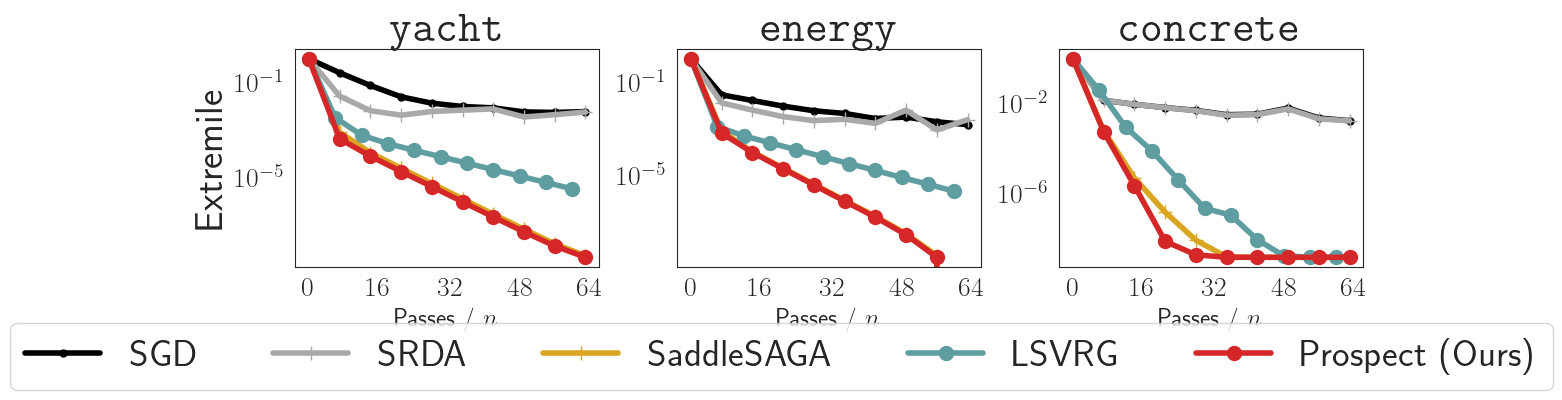

In [42]:
datasets = [
    "yacht", 
    "energy",
    "concrete",
    # "kin8nm",
    # "power"
]
objectives = [
    # "superquantile", 
    "extremile", 
    # "esrm",
]
obj_names = {
    "superquantile": "CVaR", 
    "superquantile_hard": "0.75-Superquantile", 
    "extremile": "Extremile", 
    "extremile_hard": "2.5-Extremile", 
    "esrm": "ESRM",
    "esrm_hard": "2-ESRM",
}
seeds = [1, 2]
verbose = False

sns.set_style("white")

fig, axes = plt.subplots(len(objectives), len(datasets), figsize=(4 * len(datasets), 3.5 * len(objectives)))

for i, objective in enumerate(objectives):
    for j, dataset in enumerate(datasets):

        if len(datasets) > 1 and len(objectives) > 1:
            ax = axes[i, j]
        elif len(datasets) > 1:
            ax = axes[j]
        elif len(objectives) > 1:
            ax = axes[i]
        else:
            ax = axes

        model_cfg = {
            "objective": objective, 
            "l2_reg": l2_reg, 
            "loss": "squared_error", 
            "n_class": None,
            "shift_cost": shift_cost,
        }

        for plot_cfg in plot_cfgs:
            plot_traj(
                ax, 
                dataset, 
                model_cfg, 
                plot_cfg, 
                seeds, 
                verbose=verbose,
                n_points=9,
                markersize=10,
                out_path=result_dir,
                n_epochs=32 if dataset in ["kin8nm", "power"] else None,
            )
            pass
        ax.set_xticks([])
        ax.set_yscale("log")

title_fontsize = 28
y_fontsize = 32

for i, objective in enumerate(objectives):
    if len(datasets) > 1 and len(objectives) > 1:
        ax = axes[i, 0]
    elif len(objectives) > 1:
        ax = axes[i]
    elif len(datasets) > 1:
        ax = axes[0]
    else:
        ax = axes
    ax.set_ylabel(obj_names[objective], fontsize=title_fontsize)

titles = {
    "yacht": r"{\tt yacht}", 
    "energy": r"{\tt energy}", 
    "concrete": r"{\tt concrete}",
    "kin8nm": r"{\tt kin8nm}",
    "power": r"{\tt power}",
    "iwildcam": r"{\tt iwildcam}"
}

for j, dataset in enumerate(datasets):
    if len(datasets) > 1 and len(objectives) > 1:
        ax = axes[0, j]
    elif len(datasets) > 1:
        ax = axes[j]
    else:
        ax = axes

    ax.set_title(titles[dataset], fontsize=y_fontsize)
    ax.set_xlabel(r"Passes / $n$", fontsize=18)
    if dataset in ["yacht", "concrete", "energy"]:
        ax.set_xticks([0, 16, 32, 48, 64])
    else:
        ax.set_xticks([0, 8, 16, 24, 32])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
        bbox_to_anchor=(0.5, -0.03), ncol=6)
fig.tight_layout(pad=1.0)
# plt.savefig(f"../figures/neurips/uci_training_curves_adam_reg_{l2_reg}_sm_{sm_coef}.pdf", bbox_inches="tight")
# plt.savefig(f"../figures/siamopt_uci_training_curves_reg_{l2_reg}_sm_{sm_coef}.pdf", bbox_inches="tight")
# plt.savefig(f"../figures/iclr/uci_training_curves_adam_reg_{l2_reg}_sm_{sm_coef}.pdf", bbox_inches="tight")
plt.show()